In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

import h5py
import numpy as np
import random

class PCamDataset(Dataset):
    def __init__(self, x_path, y_path, transform=None):
        super().__init__()
        self.x_path = x_path
        self.y_path = y_path
        self.transform = transform
        
        # open once for __len__ (load length)
        with h5py.File(self.x_path, 'r') as f:
            self.length = f['x'].shape[0]
        
        # ファイルはworkerごとに開くようにするためNoneで初期化
        self.x_h5 = None
        self.y_h5 = None

    def _ensure_open(self):
        # workerごとにファイルオープンが必要
        if self.x_h5 is None or self.y_h5 is None:
            self.x_h5 = h5py.File(self.x_path, 'r')
            self.y_h5 = h5py.File(self.y_path, 'r')

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        self._ensure_open()
        img = self.x_h5['x'][idx]
        label = int(self.y_h5['y'][idx].item())

        # グレースケールなら3chに変換
        if img.ndim == 2:
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
        elif img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)

        # dtypeをuint8にキャスト（ToPILImage用）
        if img.dtype != np.uint8:
            # PCamはおそらく0~255の範囲なのでastypeで良いが、念のためclipしておく
            img = np.clip(img, 0, 255).astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        return img, label

    def __del__(self):
        # ファイルを閉じる
        if self.x_h5 is not None:
            self.x_h5.close()
        if self.y_h5 is not None:
            self.y_h5.close()


# 変換
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# データセット・データローダー
train_dataset = PCamDataset(
    '/home/gotou/Medical/camelyonpatch_level_2_split_train_x.h5',
    '/home/gotou/Medical/camelyonpatch_level_2_split_train_y.h5',
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = PCamDataset(
    '/home/gotou/Medical/valid_x_uncompressed.h5',
    '/home/gotou/Medical/valid_y_uncompressed.h5',
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# 再現性確保
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# モデル準備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Training Loss: {total_loss / len(train_loader):.4f}")

    # 評価
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Validation accuracy after epoch {epoch+1}: {100 * correct / total:.2f}%")


Epoch 1/10: 100%|██████████| 8192/8192 [20:46<00:00,  6.57it/s, loss=0.0566] 

Epoch 1 Training Loss: 0.1317


Validation accuracy after epoch 1: 90.17%


Epoch 2/10: 100%|██████████| 8192/8192 [20:29<00:00,  6.66it/s, loss=0.0572] 

Epoch 2 Training Loss: 0.0708


Validation accuracy after epoch 2: 86.80%


Epoch 3/10: 100%|██████████| 8192/8192 [20:41<00:00,  6.60it/s, loss=0.0906]  

Epoch 3 Training Loss: 0.0470


Validation accuracy after epoch 3: 86.43%


Epoch 4/10: 100%|██████████| 8192/8192 [20:27<00:00,  6.67it/s, loss=0.0319]  

Epoch 4 Training Loss: 0.0325


Validation accuracy after epoch 4: 87.01%


Epoch 5/10: 100%|██████████| 8192/8192 [20:26<00:00,  6.68it/s, loss=0.0904]  

Epoch 5 Training Loss: 0.0247


Validation accuracy after epoch 5: 85.54%


Epoch 6/10: 100%|██████████| 8192/8192 [20:27<00:00,  6.67it/s, loss=0.0158]  

Epoch 6 Training Loss: 0.0203


KeyboardInterrupt: 

In [3]:
test_dataset = PCamDataset(
    '/home/gotou/Medical/camelyonpatch_level_2_split_test_y.h5',
    '/home/gotou/Medical/camelyonpatch_level_2_split_test_x.h5',
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


In [4]:
class PCamTestDataset(Dataset):
    def __init__(self, x_path, y_path, transform=None):
        super().__init__()
        self.x_h5 = h5py.File(x_path, 'r')
        self.y_h5 = h5py.File(y_path, 'r')
        self.transform = transform
        
    def __len__(self):
        return self.x_h5['x'].shape[0]
    
    def __getitem__(self, idx):
        img = self.x_h5['x'][idx]
        label = self.y_h5['y'][idx].item()
        
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.shape[2] == 1:
            img = np.concatenate([img]*3, axis=2)
        
        if self.transform:
            img = self.transform(img)
        return img, label


In [5]:
test_dataset = PCamTestDataset(
    '/home/gotou/Medical/camelyonpatch_level_2_split_test_x.h5',
    '/home/gotou/Medical/camelyonpatch_level_2_split_test_y.h5',
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test accuracy: {100 * correct / total:.2f}%')


Test accuracy: 87.82%


In [42]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    # FGSM perturbation: sign(∇_x loss)
    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images


In [94]:
epsilon = 0.03

model.eval()
adv_imgs = []

for img, label in zip(imgs, labels):
    img = img.unsqueeze(0).to(device)      # (C, H, W) → (1, C, H, W)
    label = label.unsqueeze(0).to(device)  # ラベルもバッチ化

    adv_img = fgsm_attack(model, img, label, epsilon)
    adv_imgs.append(adv_img.detach().cpu())  # detachとCPUに移して蓄積

torch.cuda.empty_cache()  # メモリの断片化も軽減
adv_imgs = torch.cat(adv_imgs)  # (N, C, H, W)

# ここから敵対的画像を用いた推論・正解率計算
correct = 0
total = 0

with torch.no_grad():
    for adv_img, label in zip(adv_imgs, labels):
        adv_img = adv_img.unsqueeze(0).to(device)
        label = label.unsqueeze(0).to(device)

        output = model(adv_img)
        pred = output.argmax(dim=1)
        correct += (pred == label).sum().item()
        total += label.size(0)

acc = 100 * correct / total
print(f'Adversarial Test Accuracy (FGSM, ε={epsilon}): {acc:.2f}%')


Adversarial Test Accuracy (FGSM, ε=0.03): 25.00%


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    super().__init__()
    self.embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim)
    )
    
    self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, padding=1, bias=False)  # 入力チャネル変更
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 4, stride=2, padding=1, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

    self.tconv3 = nn.ConvTranspose2d(channels[2]+channels[2], channels[1], 4, stride=2, padding=1, bias=False)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

    self.tconv2 = nn.ConvTranspose2d(channels[1]+channels[1], channels[0], 4, stride=2, padding=1, bias=False)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

    self.tconv1 = nn.ConvTranspose2d(channels[0]+channels[0], 3, 3, stride=1, padding=1)  # 出力チャネル変更

    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t): 
    embed = self.act(self.embed(t))
    h1 = self.act(self.gnorm1(self.conv1(x) + self.dense1(embed)))
    h2 = self.act(self.gnorm2(self.conv2(h1) + self.dense2(embed)))
    h3 = self.act(self.gnorm3(self.conv3(h2) + self.dense3(embed)))
    h4 = self.act(self.gnorm4(self.conv4(h3) + self.dense4(embed)))

    h = self.act(self.tgnorm4(self.tconv4(h4) + self.dense5(embed)))
    h = self.act(self.tgnorm3(self.tconv3(torch.cat([h, h3], dim=1)) + self.dense6(embed)))
    h = self.act(self.tgnorm2(self.tconv2(torch.cat([h, h2], dim=1)) + self.dense7(embed)))
    h = self.tconv1(torch.cat([h, h1], dim=1))

    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [24]:
import functools

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  10.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [25]:
import time

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]

  start = time.time()   # ←ここを追加
  score = model(perturbed_x, random_t)

  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss


In [26]:
class PCamDataset(torch.utils.data.Dataset):
    def __init__(self, x_path, y_path, transform=None):
        super().__init__()
        self.x_h5 = h5py.File(x_path, 'r')
        self.y_h5 = h5py.File(y_path, 'r')
        self.transform = transform

    def __len__(self):
        return self.x_h5['x'].shape[0]

    def __getitem__(self, idx):
        img = self.x_h5['x'][idx]  # (H, W, C)
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0  # (C, H, W)

        label = self.y_h5['y'][idx]  # shape: (1, 1, 1)
        label = torch.tensor(label, dtype=torch.long).squeeze()  # → shape: () スカラー
        label = label.item()  # → Pythonの int に変換（DataLoaderでバッチ時に1次元になる）

        return img, label




In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import h5py
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tqdm
import os

# -------------------------------
# モデル・関数の事前定義（省略していた場合は必要）
# → ScoreNet, marginal_prob_std_fn, loss_fn 等は定義済みと仮定
# -------------------------------

class PCamDataset(Dataset):
    def __init__(self, x_path, y_path, transform=None):
        super().__init__()
        self.x_h5 = h5py.File(x_path, 'r')
        self.y_h5 = h5py.File(y_path, 'r')
        self.transform = transform

    def __len__(self):
        return self.x_h5['x'].shape[0]

    def __getitem__(self, idx):
        img = self.x_h5['x'][idx]
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.shape[2] == 1:
            img = np.concatenate([img]*3, axis=2)
        if self.transform:
            img = self.transform(img)
        label = self.y_h5['y'][idx]
        return img, label


# ----------- パラメータ -------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 500
batch_size = 8
lr = 2e-4
sigma = 25.0
marginal_prob_std_fn = functools.partial(lambda t, sigma: torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma)), sigma=sigma)

# ----------- モデルとデータ -------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),  # 拡散モデルには軽量な画像が向いている
    transforms.ToTensor()
])

dataset = PCamDataset(
    '/home/gotou/Medical/camelyonpatch_level_2_split_train_x.h5',
    '/home/gotou/Medical/camelyonpatch_level_2_split_train_y.h5',
    transform=transform
)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn).to(device)
optimizer = Adam(score_model.parameters(), lr=lr, betas=(0.9, 0.99))

# ----------- 損失関数 -------------
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

# ----------- 学習ループ -------------
os.makedirs("checkpoints", exist_ok=True)
tqdm_epoch = tqdm.trange(n_epochs, mininterval=1.0)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    score_model.train()
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        if i >= 256:  # 必要なら短縮可
            break

    tqdm_epoch.set_description(f"Epoch {epoch+1} | Loss: {avg_loss / num_items:.4f}")

    # 100エポックごとにモデル保存
    if (epoch + 1) % 100 == 0:
        torch.save(score_model.state_dict(), f"checkpoints/score_model_epoch{epoch+1}.pth")

print(" 学習完了")
  



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 500 | Loss: 222.8709: 100%|██████████| 500/500 [51:18<00:00,  6.16s/it]

 学習完了


In [30]:
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=500, 
               snr=0.16,                 
               device='cuda',
               eps=1e-3,
               init_x=None):
    
    t = torch.ones(batch_size, device=device)

    if init_x is None:
        init_x = torch.randn(batch_size, 3, 96, 96, device=device) * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = init_x.to(device)
        if init_x.shape[2:] != (96, 96):
            import torch.nn.functional as F
            init_x = F.interpolate(init_x, size=(96, 96), mode='bilinear', align_corners=False)
    
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps, desc="PC Sampling"):
            batch_time_step = torch.ones(batch_size, device=device) * time_step

            # Langevin MCMC (Corrector step)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            grad_norm = torch.clamp(grad_norm, min=1e-5)  # ← 数値安定化

            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2

            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            # Euler-Maruyama (Predictor step)
            g = diffusion_coeff(batch_time_step).view(-1, 1, 1, 1)
            score = score_model(x, batch_time_step)
            x_mean = x + (g ** 2) * score * step_size
            x = x_mean + torch.sqrt(g ** 2 * step_size) * torch.randn_like(x)

    return x_mean


In [31]:
# モデルの保存
torch.save(score_model.state_dict(), f'ckpt_epoch_{epoch+1}.pth')

/tmp/ipykernel_182199/538274011.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score_model.load_state_dict(torch.load('ckpt_epoch_1000.pth', map_location=device))
PC Sa

/tmp/ipykernel_182199/3662202757.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
PC Sampling: 100%|██████████| 500/500 [00:04<00:00, 114.31it/s]


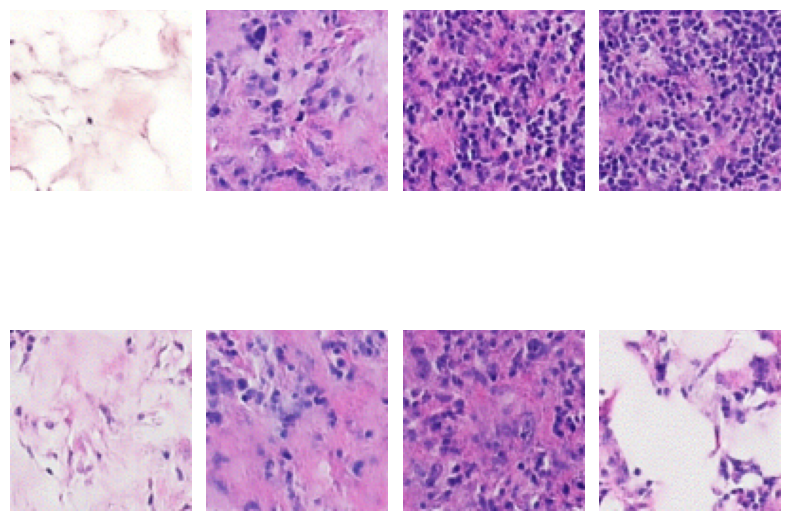

In [93]:
# 学習済みモデルの読み込み
score_model.load_state_dict(torch.load('ckpt_epoch_1000.pth', map_location=device))
score_model.eval()

# サンプリング
samples = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                     batch_size=16, num_steps=500, device=device)
# 画像の表示
import matplotlib.pyplot as plt

samples = samples.clamp(0., 1.).cpu()  # [0,1]にクリップし、CPUに移す

# 画像のグリッド表示
n_row = 2
n_col = 4
fig, axes = plt.subplots(n_row, n_col, figsize=(8, 8))

for i in range(n_row * n_col):
    ax = axes[i // n_col, i % n_col]
    img = samples[i].permute(1, 2, 0).numpy()  # (C,H,W) → (H,W,C)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [34]:
def purify_with_diffusion(adv_imgs):
    return pc_sampler(score_model, 
                      marginal_prob_std_fn, 
                      diffusion_coeff_fn,
                      batch_size=adv_imgs.size(0),
                      device=device,
                      init_x=adv_imgs)

# モデルを推論モードに
model.eval()
score_model.eval()

correct = 0
total = 0
epsilon = 0.03

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    # 敵対的画像を作成
    adv_imgs = fgsm_attack(model, imgs, labels, epsilon)

    # 拡散モデルで復元
    with torch.no_grad():
        purified_imgs = purify_with_diffusion(adv_imgs).detach()

    # 再分類
    outputs = model(purified_imgs)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy after purification (ε={epsilon}): {100 * correct / total:.2f}%")


PC Sampling:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_182199/3662202757.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
PC Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.88it/s]


Accuracy after purification (ε=0.03): 50.02%


In [48]:
import cv2
import numpy as np
import torch

def jpeg_compress_decompress(tensor_img, quality=75):
    defended_imgs = []
    for img in tensor_img:
        # Tensor (C,H,W) -> numpy (H,W,C) uint8
        img_np = (img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        result, encimg = cv2.imencode('.jpg', img_np, encode_param)
        img_dec = cv2.imdecode(encimg, 1)  # BGR
        img_dec = cv2.cvtColor(img_dec, cv2.COLOR_BGR2RGB)
        img_tensor = torch.from_numpy(img_dec).float().permute(2, 0, 1) / 255.
        defended_imgs.append(img_tensor)
    return torch.stack(defended_imgs).to(tensor_img.device)


In [ ]:
model.eval()
correct = 0
total = 0
epsilon = 0.03
jpeg_quality = 10

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    # 敵対的画像を作成
    adv_imgs = fgsm_attack(model, imgs, labels, epsilon)

    # JPEG圧縮防御
    with torch.no_grad():
        defended_imgs = jpeg_compress_decompress(adv_imgs, quality=jpeg_quality)

    # 再分類
    outputs = model(defended_imgs)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy after JPEG defense (ε={epsilon}, quality={jpeg_quality}): {100 * correct / total:.2f}%")


Accuracy after JPEG defense (ε=0.03, quality=50): 50.24%


PC Sampling:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_182199/3662202757.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
PC Sampling: 100%|██████████| 500/500 [00:02<00:00, 213.50it/s]


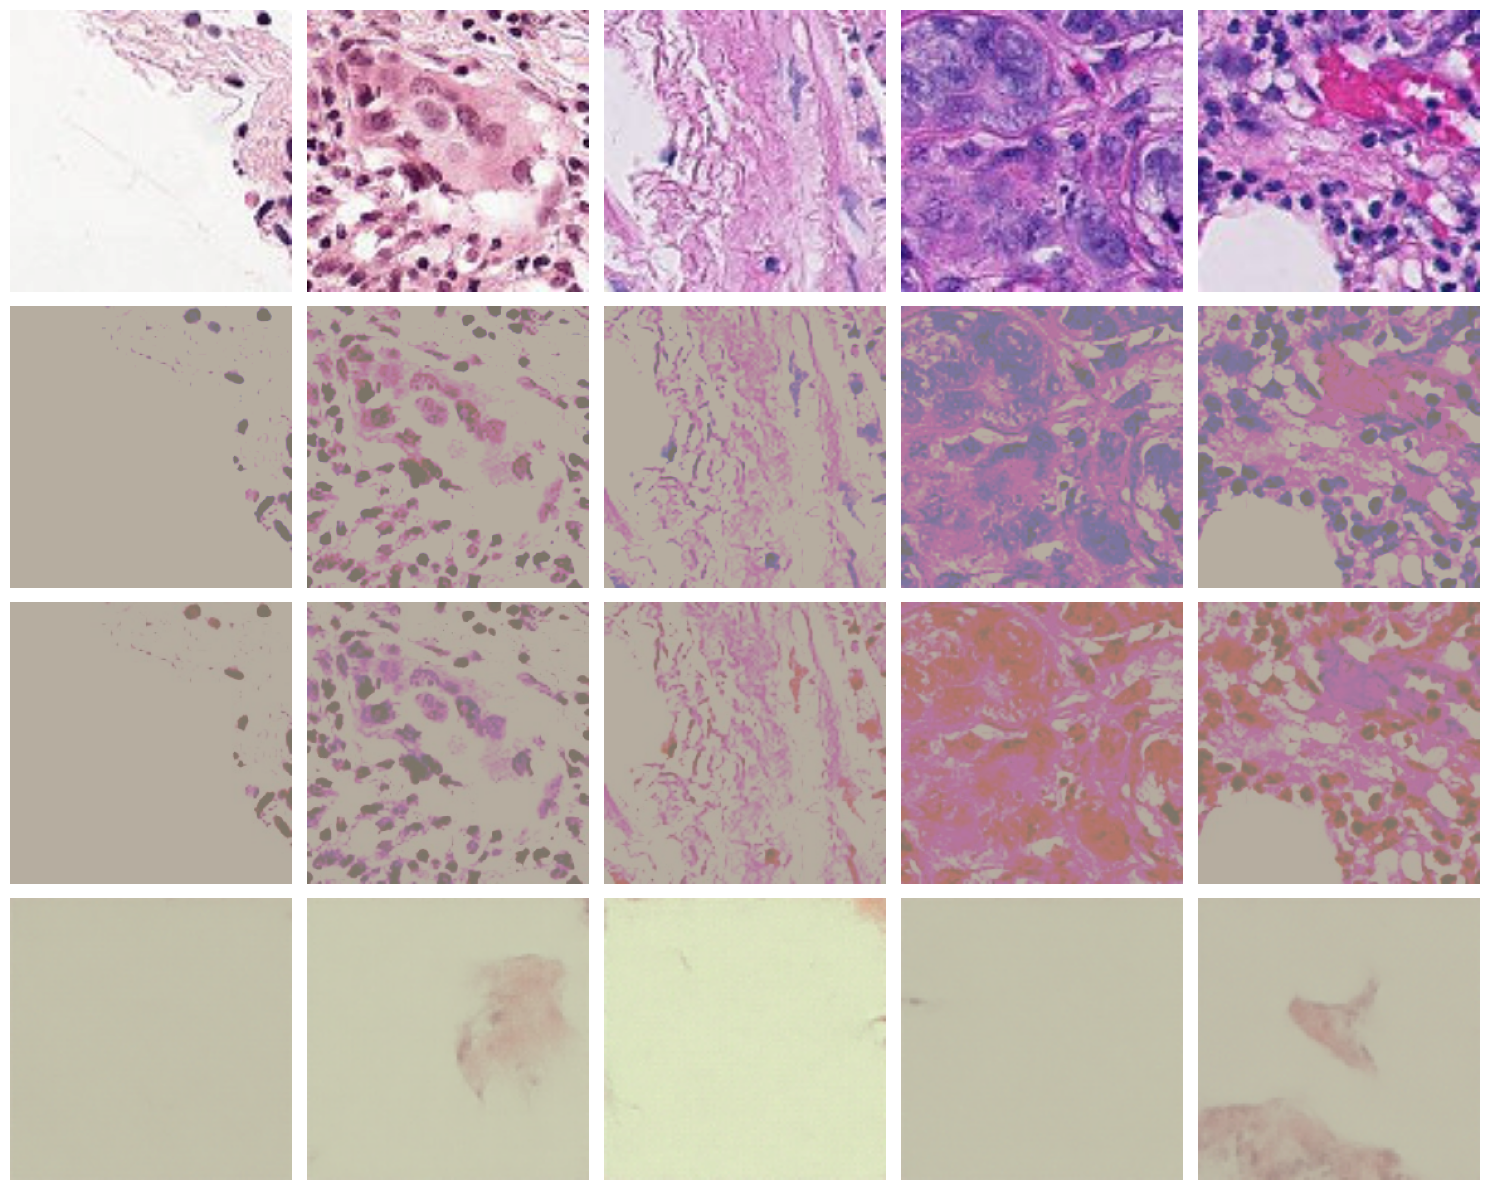

In [ ]:
def show_comparison_grid(orig_imgs, adv_imgs, jpeg_imgs, diffusion_imgs, n=5, mean=None, std=None):
    plt.figure(figsize=(3 * n, 3 * 4))  # 横3n × 縦4行分の高さ

    imgs = [orig_imgs, adv_imgs, jpeg_imgs, diffusion_imgs]
    titles = ["Original", "Adversarial", "JPEG Defense", "Diffusion Defense"]

    for row, (img_set, title) in enumerate(zip(imgs, titles)):
        for col in range(min(n, img_set.size(0))):
            img = img_set[col].cpu().clone()
            if mean is not None and std is not None:
                img = denormalize(img, mean, std)
            pil_img = transforms.ToPILImage()(img)

            plt.subplot(4, n, row * n + col + 1)
            plt.imshow(pil_img)
            plt.axis('off')
            if col == 0:
                plt.ylabel(title, fontsize=14)

    plt.tight_layout()
    plt.show()

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    adv_imgs = fgsm_attack(model, imgs, labels, epsilon)
    with torch.no_grad():
        defended_imgs = jpeg_compress_decompress(adv_imgs, quality=jpeg_quality)
        purified_imgs = purify_with_diffusion(adv_imgs).detach()

    show_comparison_grid(imgs, adv_imgs, defended_imgs, purified_imgs, n=5, mean=mean, std=std)
    break
